For evaluation purpose use eval_agent.py script. \
It will run your agent on the test environment **GridEnvDeform**.

wrap any model and make sure the following methods are implemented:\
for **POMDP** agent
- `get_action(belief,pos)` : returns the action to take given the current state
- `update_belief(self, belief, pos, observation)` : updates the belief given the current state and action

for **MDP** agent
- `get_action(pos)` : returns the action to take given the current state

**Note**: Evaluation is always performed on the **GriEnvDeform** environment. s, _ = env.reset() gives back s = ((x,y,phi),theta)


Models recap:

**MDP**
- TabularQ --------------- **OK**
- DQN -------------------- **OK**
- DQNsb3 
- PPO

**POMDP**
- TabularQ --------------- 
- DQN -------------------- 
- DQNsb3 
- PPO


quindi faccio partire mydqn pomdp e sb3dqn-mdp

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

import numpy as np
import torch
import itertools
import matplotlib.pyplot as plt

from agents.DQN_agent import DoubleDQNAgent
from environment.env import GridEnvDeform
from eval.eval import eval_agent, all_data

In [2]:
# maze size
N = 2

# thetas deformations (range(a,b),range(c,d))
l0 = 1
h0 = 10
l1 = 1
h1 = 10

maze = np.load(f"../../maze/maze_{N}.npy")
env = GridEnvDeform(maze,l0,h0,l1,h1)

states = [((x,y,phi),(i,j)) for x in range(1,env.max_shape[0]-1) for y in range(1,env.max_shape[1]-1) for phi in range(4) for i in range(l0,h0) for j in range(l1,h1)] 
positions = [(x,y,phi) for x in range(1,env.max_shape[0]-1) for y in range(1,env.max_shape[1]-1) for phi in range(4)]
actions = [0,1,2,3]
obs = list(itertools.product([0,1], repeat=5))
thetas = [(i,j) for i in range(l0,h0) for j in range(l1,h1)]

state_dict = {state: i for i, state in enumerate(states)}
position_dict = {position: i for i, position in enumerate(positions)}
obs_dict = {obs : i for i, obs in enumerate(obs)}

# Actions are: 0-listen, 1-open-left, 2-open-right
lenS = len(states)
lenP = len(positions)
lenA = len(actions)
lenO = len(obs)

lenS

236196

# Information Directed Sampling IDS

In [3]:
from agents.Infotaxis_agent import IDS, ThetaInfotaxis

import torch

# define a simple MLP that takes in input 3 and outputs 5
class SimpleMLP(torch.nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.fc1 = torch.nn.Linear(5, 128)
        self.fc2 = torch.nn.Linear(128, 128)
        self.fc3 = torch.nn.Linear(128, 128)
        self.fc4 = torch.nn.Linear(128, 5)

    def forward(self, pos,theta):
        x = torch.relu(self.fc1(torch.cat((pos,theta),1)))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return torch.sigmoid(x)

obs_model = SimpleMLP()
obs_model.load_state_dict(torch.load("obs_model_discrete.pth"))
obs_model.eval()


agent = IDS(env, obs_model)
# agent = ThetaInfotaxis(env,obs_model)

/tmp/ipykernel_54450/931294261.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  obs_model.load_state_dict(torch.load("obs_model_discrete.pth"))


In [5]:
transitions, beliefs, meanrewards, meansteps = eval_agent("POMDP",agent,env, num_episodes=1,max_episode_steps=30, render=True)
print(meanrewards, meansteps)

POMDP anyagent
eval_agent_pomdp


  0%|          | 0/1 [00:00<?, ?it/s]

Belief entropy:  2.586613655090332
Belief entropy:  1.6821322441101074
Belief entropy:  1.5883005857467651
Belief entropy:  1.5883005857467651
Belief entropy:  1.588300347328186
Belief entropy:  1.0051183700561523
Belief entropy:  1.0051183700561523
Belief entropy:  1.0051183700561523
Belief entropy:  1.0051183700561523
Belief entropy:  1.0051183700561523
Belief entropy:  1.0051183700561523
Belief entropy:  1.0051183700561523
Belief entropy:  1.0051183700561523
Belief entropy:  1.0051183700561523
Belief entropy:  1.0051183700561523
Belief entropy:  1.0051183700561523
Belief entropy:  1.0051183700561523
Belief entropy:  1.0051183700561523
Belief entropy:  1.0051183700561523
Belief entropy:  1.0051183700561523
Belief entropy:  1.0051183700561523
Belief entropy:  1.0051183700561523
Belief entropy:  1.0051183700561523
Belief entropy:  1.0051183700561523


  0%|          | 0/1 [00:12<?, ?it/s]

Belief entropy:  1.0051183700561523


error: display Surface quit

AttributeError: 'ThetaInfotaxis' object has no attribute 'belief'

-60.0 30.0


Completed episodes: 0, out of 5


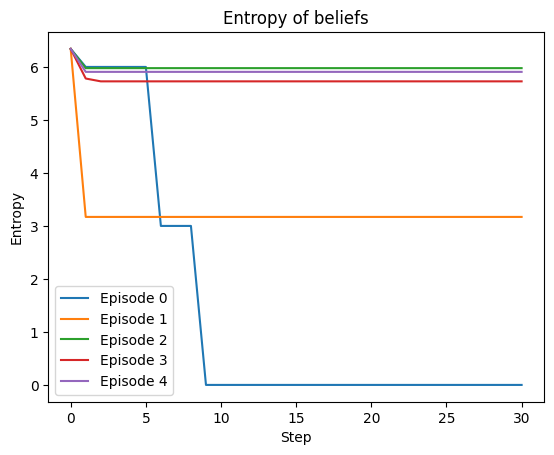

In [14]:
all_data(transitions, beliefs, path="plots/IDS")

In [6]:
import time

# transitions[i] = [(s,a,s',o)....()...] for i-th episode

# replay buffer for episode i = succession of states
episode = 4
replay_episode = [t[0] for t in transitions[episode]] 


env.set_rendering()

for i, s in enumerate(replay_episode):
    env.set_state(s)
    env.render_bis()
    time.sleep(0.5)
    
env.close_render()

NameError: name 'transitions' is not defined

# MDP based Solutions

## QMDP tabular

In [3]:
# import the MDP solution model (tabular q in this case)
Q = np.load(f"../../agents/pretrained/MDP/tabularQ_maze_2_100k.npy")

In [4]:
transitions, beliefs = eval_agent("MDP",Q ,env, num_episodes=20,max_episode_steps=50,render=True)

State: ((2, 12, 1), (4, 1)), Action: 1
State: ((12, 4, 1), (8, 6)), Action: 0
State: ((12, 5, 1), (8, 6)), Action: 1
State: ((13, 5, 2), (8, 6)), Action: 0
State: ((14, 5, 2), (8, 6)), Action: 3
State: ((14, 6, 1), (8, 6)), Action: 2
State: ((14, 5, 3), (8, 6)), Action: 2
State: ((14, 6, 1), (8, 6)), Action: 2
State: ((14, 5, 3), (8, 6)), Action: 2
State: ((14, 6, 1), (8, 6)), Action: 2
State: ((14, 5, 3), (8, 6)), Action: 2
State: ((14, 6, 1), (8, 6)), Action: 2
State: ((14, 5, 3), (8, 6)), Action: 2
State: ((14, 6, 1), (8, 6)), Action: 2
State: ((14, 5, 3), (8, 6)), Action: 2
State: ((14, 6, 1), (8, 6)), Action: 2
State: ((14, 5, 3), (8, 6)), Action: 2
State: ((14, 6, 1), (8, 6)), Action: 2
State: ((14, 5, 3), (8, 6)), Action: 2
State: ((14, 6, 1), (8, 6)), Action: 2
State: ((14, 5, 3), (8, 6)), Action: 2
State: ((14, 6, 1), (8, 6)), Action: 2
State: ((14, 5, 3), (8, 6)), Action: 2
State: ((14, 6, 1), (8, 6)), Action: 2
State: ((14, 5, 3), (8, 6)), Action: 2
State: ((14, 6, 1), (8, 6

In [5]:
from agents.Tabular_Q_agent import Q_agent, Thompson_agent
    
qagent = Q_agent(Q,env)
tagent = Thompson_agent(Q,env)


In [14]:
transitions, beliefs = eval_agent("POMDP",tagent ,env, num_episodes=20,max_episode_steps=50,render=True)

POMDP
eval_agent_pomdp


  0%|          | 0/20 [00:00<?, ?it/s]

State ((23, 5, 3), (8, 3))
Action:  2
Reward:     -2.0  
Next State:  ((23, 6, 1), (8, 3))
argmax and max Belief:  (1, 1) tensor(0.0154)
Belief entropy:  tensor(4.1744)


State ((23, 6, 1), (8, 3))
Action:  0
Reward:     -4.0  
Next State:  ((23, 7, 1), (8, 3))
argmax and max Belief:  (1, 1) tensor(0.0154)
Belief entropy:  tensor(4.1744)


State ((23, 7, 1), (8, 3))
Action:  3
Reward:     -6.0  
Next State:  ((22, 7, 0), (8, 3))
argmax and max Belief:  (1, 1) tensor(0.0175)
Belief entropy:  tensor(4.0431)


State ((22, 7, 0), (8, 3))
Action:  3
Reward:     -8.0  
Next State:  ((22, 6, 3), (8, 3))
argmax and max Belief:  (1, 1) tensor(0.0175)
Belief entropy:  tensor(4.0431)


State ((22, 6, 3), (8, 3))
Action:  2
Reward:     -10.0  
Next State:  ((22, 7, 1), (8, 3))
argmax and max Belief:  (1, 1) tensor(0.0175)
Belief entropy:  tensor(4.0431)


State ((22, 7, 1), (8, 3))
Action:  0
Reward:     -12.0  
Next State:  ((22, 8, 1), (8, 3))
argmax and max Belief:  (1, 1) tensor(0.0175)
Belief

  0%|          | 0/20 [00:00<?, ?it/s]

State ((9, 11, 1), (8, 3))
Action:  0
Reward:     -67.0  
Next State:  ((9, 12, 1), (8, 3))
argmax and max Belief:  (5, 3) tensor(0.2000)
Belief entropy:  tensor(1.6094)


State ((9, 12, 1), (8, 3))
Action:  0
Reward:     -67.5  
Next State:  ((9, 13, 1), (8, 3))
argmax and max Belief:  (5, 3) tensor(0.2000)
Belief entropy:  tensor(1.6094)




AttributeError: 'GridEnvDeform' object has no attribute 'pause'

In [4]:
env.set_rendering()

In [ ]:
env.render_tris(((3,1,0),(9,4)),(9,15))

: 

In [13]:
env.render_bis()

In [6]:
env.save_gif()

GIF saved as gif


Completed episodes: 15, out of 20


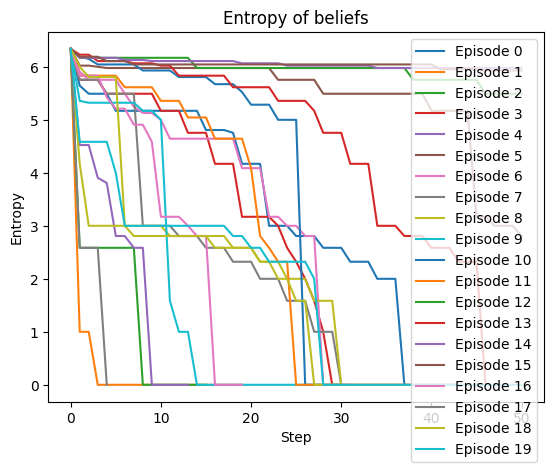

In [13]:
all_data(transitions, beliefs, path="plots/Thompson")

In [24]:
env.set_rendering()
while True:
    try:
        env.render_bis()
    except:
        break

## DQN 

In [14]:
agent = DoubleDQNAgent(5, 4, lr = 0.01, batch_size=64,target_update_freq=100, wandb=False)
agent.load("../../agents/pretrained/MDP/double_dqn_45000.pt") # 2100 is FIB ---- 45000 is DQN

In [15]:
eval_agent("MDP",agent,env, num_episodes=1000,max_episode_steps=100,render=False)

MDP - DQN


(-19.4445, 18.51)

In [16]:
# MLS
meanreward, meansteps = eval_agent("POMDP",agent,env, num_episodes=100,max_episode_steps=100,render=False)
print(meanreward, meansteps)

POMDP - DQN
MLS
-26.47 23.93


In [17]:
class QMDP_agent():
    def __init__(self, Q:DoubleDQNAgent,env):
        self.Q = Q
        self.env = env

    def get_entropy(self, belief):
        return -torch.sum(belief * torch.log(belief + 1e-10))

    def get_action(self, belief, pos):
        """belief : discrete distribution over thetas
        pos : current position of the agent
        """
        # QMDP averages belief * Q values
        states = torch.cat([torch.tensor([pos[0],pos[1],pos[2],theta[0],theta[1]],dtype=torch.float32).unsqueeze(0) for theta in self.env.deformations])
        # print(states.shape)
        # print(states[:5])
        with torch.no_grad():
            q_values = self.Q.q_network(states)

        # print(q_values.shape)
        # print(q_values[:5])
        q_values = q_values.view(len(self.env.deformations),-1)

        # average over theta beliefs
        actions = torch.einsum('t,ta-> a',belief,q_values)        
        # print(actions)        
        return torch.argmax(actions).item()

    def update_belief(self, belief, pos, observation):
        """"
        perform update over theta
        
        $$b'_{x,a,o}(theta) = \eta \cdot p(o|x,theta) \cdot b(theta)$$
        
        """

        new_belief = torch.zeros_like(belief)

        for t, theta in enumerate(self.env.deformations):
            P_o_s_theta = np.all(self.env.get_observation(s = (pos,theta)) == observation) # 0 or 1 

            new_belief[t] = P_o_s_theta * belief[t]
        
        new_belief = new_belief / (torch.sum(new_belief) + 1e-10)

        return new_belief


In [18]:
QMDP = QMDP_agent(agent,env)

transitions, beliefs, meanreward, meansteps = eval_agent("POMDP",QMDP,env, num_episodes=1000,max_episode_steps=100,render=False)
print(meanreward, meansteps)

POMDP anyagent
eval_agent_pomdp


100%|██████████| 1000/1000 [05:06<00:00,  3.26it/s]

-24.46 23.141


In [ ]:
all_data(transitions, beliefs, path="plots/QMDP")

In [19]:
class Sample_agent():
    def __init__(self, Q,env):
        self.Q = Q
        self.env = env

    def get_entropy(self, belief):
        return -torch.sum(belief * torch.log(belief + 1e-10))

    def get_action(self, belief,pos):
        theta = self.env.deformations[torch.multinomial(belief, 1).item()]

        s = (pos[0],pos[1],pos[2],theta[0],theta[1])

        # Agent takes an action using a greedy policy (without exploration)
        action = self.Q.choose_deterministic_action(s)
        return action
    
    def update_belief(self, belief, pos, observation):
        """"
        perform update over theta
        
        $$b'_{x,a,o}(theta) = \eta \cdot p(o|x,theta) \cdot b(theta)$$
        
        """

        new_belief = torch.zeros_like(belief)

        for t, theta in enumerate(self.env.deformations):
            P_o_s_theta = np.all(self.env.get_observation(s = (pos,theta)) == observation) # 0 or 1 

            new_belief[t] = P_o_s_theta * belief[t]
        
        new_belief = new_belief / (torch.sum(new_belief) + 1e-10)

        return new_belief


In [20]:
pomdp_agent = Sample_agent(agent,env)

In [21]:
# thompson sampling
transitions, beliefs, meanreward, meansteps = eval_agent("POMDP",pomdp_agent,env, num_episodes=1000,max_episode_steps=100,render=False)
print(meanreward, meansteps)

POMDP anyagent
eval_agent_pomdp


100%|██████████| 1000/1000 [04:54<00:00,  3.40it/s]

-26.13 24.231


Completed episodes: 50, out of 50


FileNotFoundError: [Errno 2] No such file or directory: '/home/flaccagora/Desktop/RoboSurgery/old_discrete/src/test/discrete_tests/plots/SAMPLINGSTATEentropy_50out50.png'

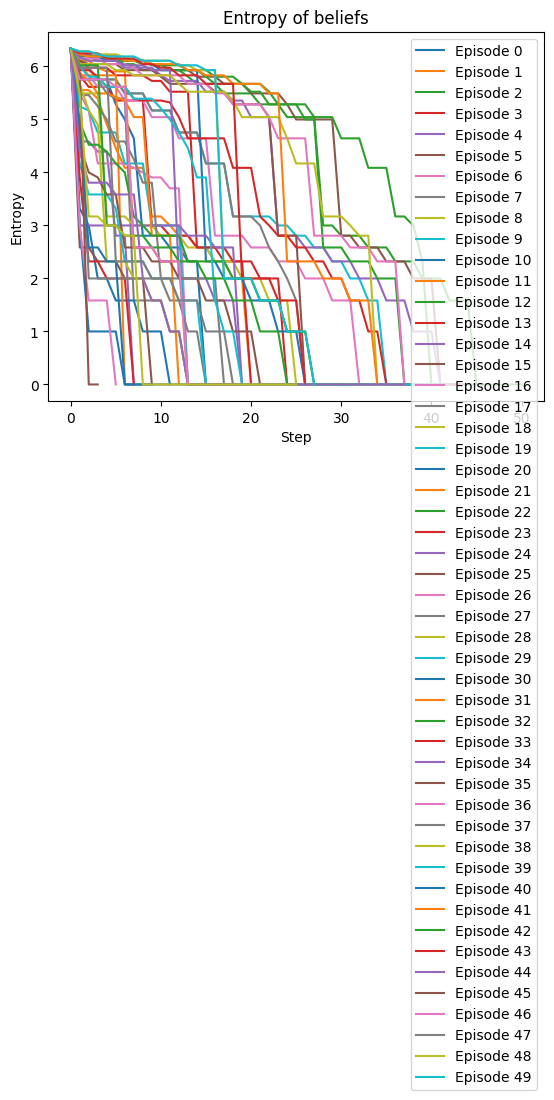

In [20]:
all_data(transitions, beliefs, path="plots/SAMPLINGSTATE")

## DQN sb3

In [10]:
from stable_baselines3 import DQN
from environment.env import MDPGYMGridEnvDeform

env = MDPGYMGridEnvDeform(maze,l0,h0,l1,h1)
model = DQN.load("../../agents/pretrained/MDP/doubl", env=env)

FileNotFoundError: [Errno 2] No such file or directory: '../../agents/pretrained/MDP/double_dqn_45000.zip'

In [4]:
from collections import OrderedDict

class MDP_DQNsb3():
    def __init__(self, model):
        self.model = model

    def get_action(self,s):
        print(s)
        s = OrderedDict({
                "phi": torch.tensor([s[0][2]]),             # Values from 0 to 4
                "theta": torch.tensor(s[1]) ,                                
                "x": torch.tensor([s[0][0]]),              # Values from 0 to 10
                "y": torch.tensor([s[0][1]]),              # Values from 0 to 10
            })
        print(s)
        # Agent takes an action using a greedy policy (without exploration)
        action = self.model.predict(s,deterministic=True)[0]
        return action
    
mdpmodel = MDP_DQNsb3(model)

In [11]:
eval_agent("MDP",mdpmodel,env, num_episodes=1,max_episode_steps=100,render=False)

  0%|          | 0/1 [00:00<?, ?it/s]

((2, 22, 2), (9, 3))
OrderedDict([('phi', tensor([2])), ('theta', tensor([9, 3])), ('x', tensor([2])), ('y', tensor([22]))])
((3, 22, array([2])), (9, 3))
OrderedDict([('phi', tensor([[2]])), ('theta', tensor([9, 3])), ('x', tensor([3])), ('y', tensor([22]))])


ValueError: Error: Unexpected observation shape (1, 1) for Discrete environment, please use () or (n_env,) for the observation shape.

In [5]:
from collections import OrderedDict

class DeepThompson_DQNsb3():
    def __init__(self, model,env):
        self.model = model
        self.env = env

    def get_entropy(self, belief):
        return -torch.sum(belief * torch.log(belief + 1e-10))

    def get_action(self, belief,pos):
        theta = self.env.deformations[torch.multinomial(belief, 1).item()]

        s = OrderedDict({
                "x": torch.tensor([pos[0]],dtype=torch.int32),              # Values from 0 to 10
                "y": torch.tensor([pos[1]],dtype=torch.int32),              # Values from 0 to 10
                "phi": torch.tensor([pos[2]],dtype=torch.int32),             # Values from 0 to 4
                "theta": torch.tensor(theta) , # Probability vector
            })
 
        # Agent takes an action using a greedy policy (without exploration)
        action = self.model.predict(s,deterministic=True)[0]
        return action
    
    def update_belief(self, belief, pos, observation):
        """"
        perform update over theta
        
        $$b'_{x,a,o}(theta) = \eta \cdot p(o|x,theta) \cdot b(theta)$$
        
        """

        new_belief = torch.zeros_like(belief)

        for t, theta in enumerate(self.env.deformations):
            P_o_s_theta = np.all(self.env.get_observation(s = (pos,theta)) == observation) # 0 or 1 

            new_belief[t] = P_o_s_theta * belief[t]
        
        new_belief = new_belief / (torch.sum(new_belief) + 1e-10)

        return new_belief

pomdp_agent = DeepThompson_DQNsb3(model,env)

## DQN

In [84]:
agent = DoubleDQNAgent(84, 4, lr = 0.01, batch_size=64,target_update_freq=100, wandb=False)
agent.load("agents/pretrained/POMDP/double_dqn_8000.pt")

In [85]:
class POMDP_DQN():
    def __init__(self, model,env):
        self.model = model
        self.env = env

    def get_entropy(self, belief):
        return -torch.sum(belief * torch.log(belief + 1e-10))

    def get_action(self, belief,pos):

        action = self.model.choose_deterministic_action(torch.cat((torch.tensor(pos),belief)))
        return action
    
    def update_belief(self, belief, pos, observation):
        """"
        perform update over theta
        
        $$b'_{x,a,o}(theta) = \eta \cdot p(o|x,theta) \cdot b(theta)$$
        
        """

        new_belief = torch.zeros_like(belief)

        for t, theta in enumerate(self.env.deformations):
            P_o_s_theta = np.all(self.env.get_observation(s = (pos,theta)) == observation) # 0 or 1 

            new_belief[t] = P_o_s_theta * belief[t]
        
        new_belief = new_belief / (torch.sum(new_belief) + 1e-10)

        return new_belief

pomdp_agent = POMDP_DQN(agent,env)

In [86]:
eval_agent("POMDP",pomdp_agent,env, num_episodes=10,max_episode_steps=50,render=True)

POMDP
eval_agent_pomdp


  0%|          | 0/10 [00:00<?, ?it/s]

State ((26, 25, 1), (4, 2))
Action:  2
Reward:     -2.0  
Next State:  ((26, 24, 3), (4, 2))
argmax and max Belief:  (1, 1) tensor(0.0127)
Belief entropy:  tensor(4.3694)


State ((26, 24, 3), (4, 2))
Action:  2
Reward:     -4.0  
Next State:  ((26, 25, 1), (4, 2))
argmax and max Belief:  (1, 1) tensor(0.0127)
Belief entropy:  tensor(4.3694)


State ((26, 25, 1), (4, 2))
Action:  2
Reward:     -6.0  
Next State:  ((26, 24, 3), (4, 2))
argmax and max Belief:  (1, 1) tensor(0.0127)
Belief entropy:  tensor(4.3694)


State ((26, 24, 3), (4, 2))
Action:  2
Reward:     -8.0  
Next State:  ((26, 25, 1), (4, 2))
argmax and max Belief:  (1, 1) tensor(0.0127)
Belief entropy:  tensor(4.3694)


State ((26, 25, 1), (4, 2))
Action:  2
Reward:     -10.0  
Next State:  ((26, 24, 3), (4, 2))
argmax and max Belief:  (1, 1) tensor(0.0127)
Belief entropy:  tensor(4.3694)


State ((26, 24, 3), (4, 2))
Action:  2
Reward:     -12.0  
Next State:  ((26, 25, 1), (4, 2))
argmax and max Belief:  (1, 1) tensor(0.

 10%|█         | 1/10 [00:01<00:12,  1.33s/it]

State ((26, 25, 1), (4, 2))
Action:  2
Reward:     -98.0  
Next State:  ((26, 24, 3), (4, 2))
argmax and max Belief:  (1, 1) tensor(0.0127)
Belief entropy:  tensor(4.3694)


State ((26, 24, 3), (4, 2))
Action:  2
Reward:     -100.0  
Next State:  ((26, 25, 1), (4, 2))
argmax and max Belief:  (1, 1) tensor(0.0127)
Belief entropy:  tensor(4.3694)


State ((17, 10, 3), (3, 6))
Action:  2
Reward:     -2.0  
Next State:  ((17, 11, 1), (3, 6))
argmax and max Belief:  (1, 1) tensor(0.0164)
Belief entropy:  tensor(4.1109)


State ((17, 11, 1), (3, 6))
Action:  2
Reward:     -4.0  
Next State:  ((17, 10, 3), (3, 6))
argmax and max Belief:  (3, 6) tensor(0.2000)
Belief entropy:  tensor(1.6094)


State ((17, 10, 3), (3, 6))
Action:  2
Reward:     -6.0  
Next State:  ((17, 11, 1), (3, 6))
argmax and max Belief:  (3, 6) tensor(0.2000)
Belief entropy:  tensor(1.6094)


State ((17, 11, 1), (3, 6))
Action:  2
Reward:     -8.0  
Next State:  ((17, 10, 3), (3, 6))
argmax and max Belief:  (3, 6) tensor(0

 20%|██        | 2/10 [00:02<00:10,  1.37s/it]

State ((17, 11, 1), (3, 6))
Action:  2
Reward:     -92.0  
Next State:  ((17, 10, 3), (3, 6))
argmax and max Belief:  (3, 6) tensor(0.2000)
Belief entropy:  tensor(1.6094)


State ((17, 10, 3), (3, 6))
Action:  2
Reward:     -94.0  
Next State:  ((17, 11, 1), (3, 6))
argmax and max Belief:  (3, 6) tensor(0.2000)
Belief entropy:  tensor(1.6094)


State ((17, 11, 1), (3, 6))
Action:  2
Reward:     -96.0  
Next State:  ((17, 10, 3), (3, 6))
argmax and max Belief:  (3, 6) tensor(0.2000)
Belief entropy:  tensor(1.6094)


State ((17, 10, 3), (3, 6))
Action:  2
Reward:     -98.0  
Next State:  ((17, 11, 1), (3, 6))
argmax and max Belief:  (3, 6) tensor(0.2000)
Belief entropy:  tensor(1.6094)


State ((17, 11, 1), (3, 6))
Action:  2
Reward:     -100.0  
Next State:  ((17, 10, 3), (3, 6))
argmax and max Belief:  (3, 6) tensor(0.2000)
Belief entropy:  tensor(1.6094)


State ((13, 23, 0), (3, 2))
Action:  2
Reward:     -2.0  
Next State:  ((14, 23, 2), (3, 2))
argmax and max Belief:  (1, 1) tenso

 30%|███       | 3/10 [00:04<00:09,  1.38s/it]

State ((14, 23, 2), (3, 2))
Action:  2
Reward:     -100.0  
Next State:  ((13, 23, 0), (3, 2))
argmax and max Belief:  (1, 1) tensor(0.0145)
Belief entropy:  tensor(4.2341)


State ((21, 15, 0), (9, 2))
Action:  2
Reward:     -2.0  
Next State:  ((22, 15, 2), (9, 2))
argmax and max Belief:  (1, 1) tensor(0.0141)
Belief entropy:  tensor(4.2627)


State ((22, 15, 2), (9, 2))
Action:  2
Reward:     -4.0  
Next State:  ((21, 15, 0), (9, 2))
argmax and max Belief:  (1, 1) tensor(0.0152)
Belief entropy:  tensor(4.1897)


State ((21, 15, 0), (9, 2))
Action:  2
Reward:     -6.0  
Next State:  ((22, 15, 2), (9, 2))
argmax and max Belief:  (1, 1) tensor(0.0152)
Belief entropy:  tensor(4.1897)


State ((22, 15, 2), (9, 2))
Action:  2
Reward:     -8.0  
Next State:  ((21, 15, 0), (9, 2))
argmax and max Belief:  (1, 1) tensor(0.0152)
Belief entropy:  tensor(4.1897)


State ((21, 15, 0), (9, 2))
Action:  2
Reward:     -10.0  
Next State:  ((22, 15, 2), (9, 2))
argmax and max Belief:  (1, 1) tensor(0

 40%|████      | 4/10 [00:05<00:08,  1.40s/it]

State ((22, 15, 2), (9, 2))
Action:  2
Reward:     -92.0  
Next State:  ((21, 15, 0), (9, 2))
argmax and max Belief:  (1, 1) tensor(0.0152)
Belief entropy:  tensor(4.1897)


State ((21, 15, 0), (9, 2))
Action:  2
Reward:     -94.0  
Next State:  ((22, 15, 2), (9, 2))
argmax and max Belief:  (1, 1) tensor(0.0152)
Belief entropy:  tensor(4.1897)


State ((22, 15, 2), (9, 2))
Action:  2
Reward:     -96.0  
Next State:  ((21, 15, 0), (9, 2))
argmax and max Belief:  (1, 1) tensor(0.0152)
Belief entropy:  tensor(4.1897)


State ((21, 15, 0), (9, 2))
Action:  2
Reward:     -98.0  
Next State:  ((22, 15, 2), (9, 2))
argmax and max Belief:  (1, 1) tensor(0.0152)
Belief entropy:  tensor(4.1897)


State ((22, 15, 2), (9, 2))
Action:  2
Reward:     -100.0  
Next State:  ((21, 15, 0), (9, 2))
argmax and max Belief:  (1, 1) tensor(0.0152)
Belief entropy:  tensor(4.1897)


State ((7, 24, 2), (3, 6))
Action:  2
Reward:     -2.0  
Next State:  ((6, 24, 0), (3, 6))
argmax and max Belief:  (1, 1) tensor(

 40%|████      | 4/10 [00:06<00:10,  1.68s/it]

State ((7, 24, 2), (3, 6))
Action:  2
Reward:     -74.0  
Next State:  ((6, 24, 0), (3, 6))
argmax and max Belief:  (1, 1) tensor(0.0154)
Belief entropy:  tensor(4.1744)




error: display Surface quit